# Phase Identification NN

Developement of a neural network capable of identifying the phase of a 2D system (liquid, hexatic or solid)

In [2]:
import tensorflow as tf

import glob
import numpy as np
import matplotlib.pyplot as plt

2023-01-29 16:23:21.248931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 16:23:21.555080: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-29 16:23:21.622139: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-29 16:23:21.622157: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Load data

First, let us load the data

## Data from $N = 64^2$ 

This is the smallest size (and in the other cases the system will be splitted to fit this size)

In [3]:
data_64 = np.load('dataset/dataset_64/dataset_64.npy')
labels_64 = np.load('dataset/dataset_64/dataset_labels_64.npy')

data_64 = data_64.astype('float32')
labels_64 = labels_64.astype('int32')

np.save('dataset/dataset_64/dataset_64.npy', data_64)
np.save('dataset/dataset_64/dataset_labels_64.npy', labels_64)

In [2]:
data_64 = np.load('dataset/dataset_64/dataset_64.npy')
labels_64 = np.load('dataset/dataset_64/dataset_labels_64.npy')

## Data from $N = 128^2$

In [2]:
def split_sys_in_squares(pos, label, edge_size):
    '''This function takes in a list of x,y coordinates and splits them up into
    smaller boxes with the size of edge_size. The boxes are returned in a list.'''
    padding_number = int(np.sqrt(len(pos[:,0]))*edge_size)
    padding_number = padding_number**2
    num_boxes = int(1 / edge_size)
    smaller_boxes = [[] for _ in range((num_boxes) * (num_boxes))]
    for x, y in pos:
        if (x > 1 or y > 1):
            raise ValueError('x and y must be between 0 and 1')
        if (int(x/edge_size)<num_boxes):
            box_x = int(x / edge_size)
        else:
            continue 
        if (int(y/edge_size)<num_boxes):
            box_y = int(y / edge_size) 
        else:
            continue
        #print(num_boxes * num_boxes + 1, box_x + box_y * num_boxes )
        smaller_boxes[box_x + box_y * num_boxes].append((x, y))

    for i in range(len(smaller_boxes)):
        smaller_boxes[i] = np.array(smaller_boxes[i])
        # shift the box to the origin
        smaller_boxes[i][:,0] = smaller_boxes[i][:,0] - (i % num_boxes) * edge_size
        smaller_boxes[i][:,1] = smaller_boxes[i][:,1] - (i // num_boxes) * edge_size
        # scale the box to the size of 1
        smaller_boxes[i][:,0] = smaller_boxes[i][:,0] / edge_size
        smaller_boxes[i][:,1] = smaller_boxes[i][:,1] / edge_size

        if smaller_boxes[i].shape[0] < padding_number:
            # pad the array with zeros
            smaller_boxes[i] = np.pad(smaller_boxes[i], ((0, padding_number - smaller_boxes[i].shape[0]), (0, 0)), 'constant')
        if smaller_boxes[i].shape[0] > padding_number:
            # cut the array
            smaller_boxes[i] = smaller_boxes[i][:padding_number]
        #print(smaller_boxes[i].shape)
    # now duplicate the labels
    new_labels = []
    for i in range(len(smaller_boxes)):
        new_labels.append(label)
    
    return np.array(smaller_boxes), np.array(new_labels)
    

#plt.plot(new_pos[5][:,0], new_pos[5][:,1], 'o', markersize=1)

In [69]:
splitted_conf, splitted_labels = split_sys_in_squares(data[17], labels[17], 0.5)
print(labels[4000], splitted_labels)


1 [0 0 0 0]


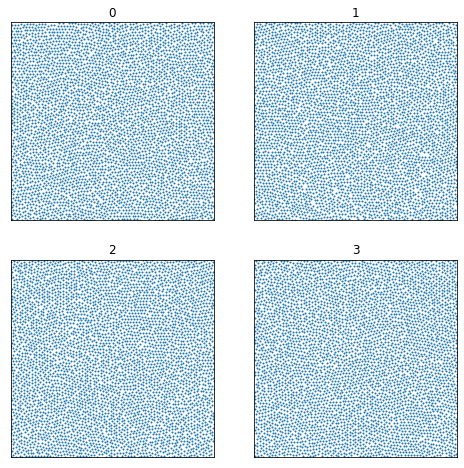

In [ ]:
# plot the four configuration in a figure 2x2
fig, axs = plt.subplots(2, 2, figsize=(8,8))
for i in range(2):
    for j in range(2):
        axs[i,j].plot(splitted_conf[i*2+j][:,0], splitted_conf[i*2+j][:,1], 'o', markersize=1)
        axs[i,j].set_title(i*2+j)
        axs[i,j].set_xlim(0,1)
        axs[i,j].set_ylim(0,1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
plt.show()

In [4]:
# loop over all the data and split it up, then concatenate in a new array
new_data = []
new_labels = []
for i in range(len(data)):
    if i % 100 == 0:
        print(f"{i/len(data)*100:.2f}", '%', end='\r')
    splitted_conf, splitted_labels = split_sys_in_squares(data[i], labels[i], 0.5)
    new_data.append(splitted_conf)
    new_labels.append(splitted_labels)

new_data = np.concatenate(new_data)
new_labels = np.concatenate(new_labels)

print(new_data.shape, new_labels.shape)

(27912, 4096, 2) (27912,)


In [7]:
data_128 = np.load('dataset/dataset_128/splitted_dataset_128.npy')
labels_128 = np.load('dataset/dataset_128/splitted_dataset_labels_128.npy')

data_128 = data_128.astype('float32')
labels_128 = labels_128.astype('int32')

np.save('dataset/dataset_128/splitted_dataset_128.npy', data_128)
np.save('dataset/dataset_128/splitted_dataset_labels_128.npy', labels_128)

In [3]:
data_128 = np.load('dataset/dataset_128/splitted_dataset_128.npy')
labels_128 = np.load('dataset/dataset_128/splitted_dataset_labels_128.npy')

In [3]:
print(data_128.shape, labels_128.shape)

(27912, 4096, 2) (27912,)


## Data from N = 256^2

In [3]:
def split_sys_in_squares(pos, label, edge_size):
    '''This function takes in a list of x,y coordinates and splits them up into
    smaller boxes with the size of edge_size. The boxes are returned in a list.'''
    padding_number = int(np.sqrt(len(pos[:,0]))*edge_size)
    padding_number = padding_number**2
    num_boxes = int(1 / edge_size)
    smaller_boxes = [[] for _ in range((num_boxes) * (num_boxes))]
    for x, y in pos:
        if (x > 1 or y > 1):
            raise ValueError('x and y must be between 0 and 1')
        if (int(x/edge_size)<num_boxes):
            box_x = int(x / edge_size)
        else:
            continue 
        if (int(y/edge_size)<num_boxes):
            box_y = int(y / edge_size) 
        else:
            continue
        #print(num_boxes * num_boxes + 1, box_x + box_y * num_boxes )
        smaller_boxes[box_x + box_y * num_boxes].append((x, y))

    for i in range(len(smaller_boxes)):
        smaller_boxes[i] = np.array(smaller_boxes[i])
        # shift the box to the origin
        smaller_boxes[i][:,0] = smaller_boxes[i][:,0] - (i % num_boxes) * edge_size
        smaller_boxes[i][:,1] = smaller_boxes[i][:,1] - (i // num_boxes) * edge_size
        # scale the box to the size of 1
        smaller_boxes[i][:,0] = smaller_boxes[i][:,0] / edge_size
        smaller_boxes[i][:,1] = smaller_boxes[i][:,1] / edge_size

        if smaller_boxes[i].shape[0] < padding_number:
            # pad the array with zeros
            smaller_boxes[i] = np.pad(smaller_boxes[i], ((0, padding_number - smaller_boxes[i].shape[0]), (0, 0)), 'constant')
        if smaller_boxes[i].shape[0] > padding_number:
            # cut the array
            smaller_boxes[i] = smaller_boxes[i][:padding_number]
        #print(smaller_boxes[i].shape)
    # now duplicate the labels
    new_labels = []
    for i in range(len(smaller_boxes)):
        new_labels.append(label)
    
    return np.array(smaller_boxes), np.array(new_labels)
    

#plt.plot(new_pos[5][:,0], new_pos[5][:,1], 'o', markersize=1)

In [ ]:
# loop over all the data and split it up, then concatenate in a new array
max_confs = 100_000
all_data = np.zeros( (max_confs, 4096, 2), dtype='float32')
all_labels = np.zeros( max_confs, dtype='int32')

tot_conf = 0
for dataset in range(1, 9):
    print(f"dataset {dataset}", end='\n')
    data = np.load(f'dataset/dataset_256/dataset_{dataset}.npy').astype('float32')
    labels = np.load(f'dataset/dataset_256/dataset_labels_{dataset}.npy').astype('int32')
    for i in range(len(data)):
        if i % 100 == 0:
            print(f"{i/len(data)*100:.2f}", '%', end='\r')
        splitted_conf, splitted_labels = split_sys_in_squares(data[i], labels[i], 0.25)
        all_data[tot_conf:tot_conf+splitted_conf.shape[0]] = splitted_conf
        all_labels[tot_conf:tot_conf+splitted_conf.shape[0]] = splitted_labels
        tot_conf += splitted_conf.shape[0]
        if tot_conf >= max_confs:
            break
    if tot_conf >= max_confs:
        break
    
all_data = all_data[:tot_conf]
#all_data = np.concatenate(all_data)
#all_labels = np.concatenate(all_labels)
print(all_data.shape, all_labels.shape)


dataset 1
dataset 2
dataset 3
dataset 4
dataset 5
dataset 6
dataset 7
dataset 8
(59568, 4096, 2) (100000,)


In [ ]:
#all_data = all_data[:tot_conf]
all_labels = all_labels[:tot_conf]

np.save('dataset/dataset_256/splitted_dataset_256.npy', all_data)
np.save('dataset/dataset_256/splitted_dataset_labels_256.npy', all_labels)

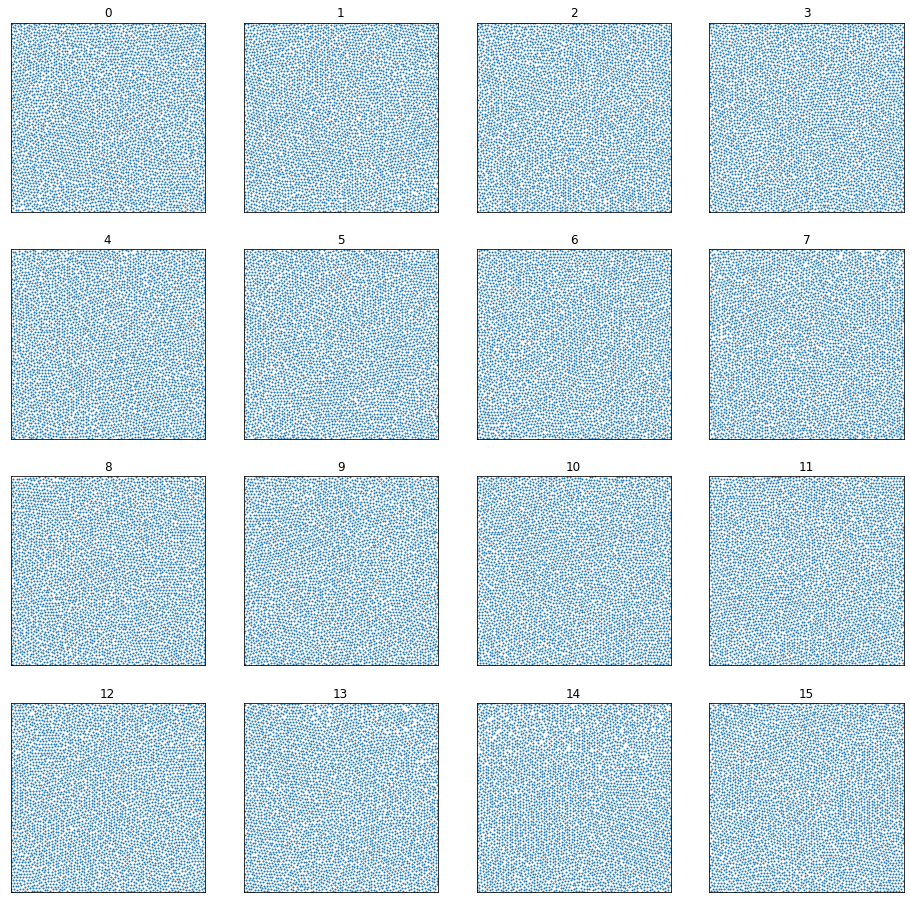

In [ ]:
# plot the four configuration in a figure 2x2
fig, axs = plt.subplots(4, 4, figsize=(16,16))
for i in range(4):
    for j in range(4):
        axs[i,j].plot(splitted_conf[i*4+j][:,0], splitted_conf[i*4+j][:,1], 'o', markersize=1)
        axs[i,j].set_title(i*4+j)
        axs[i,j].set_xlim(0,1)
        axs[i,j].set_ylim(0,1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
plt.show()

In [4]:
data_256 = np.load('dataset/dataset_256/splitted_dataset_256.npy')
labels_256 = np.load('dataset/dataset_256/splitted_dataset_labels_256.npy')

## Concatenate datasets

In [5]:
# data_64 = data_64.astype('float32')
# data_128 = data_128.astype('float32')
# data_256 = data_256.astype('float32')

# labels_64 = labels_64.astype('int32')
# labels_128 = labels_128.astype('int32')
# labels_256 = labels_256.astype('int32')


print(data_64.shape, labels_64.shape)
print(data_128.shape, labels_128.shape)
print(data_256.shape, labels_256.shape)

(6930, 4096, 2) (6930,)
(27912, 4096, 2) (27912,)
(59568, 4096, 2) (59568,)


In [6]:
# join the two datasets
new_data = np.concatenate((data_64, data_128, data_256))
new_labels = np.concatenate((labels_64, labels_128, labels_256))

del data_64, data_128, data_256, labels_64, labels_128, labels_256

print(new_data.shape, new_labels.shape)

(94410, 4096, 2) (94410,)


In [7]:
# split the data and labels into training, validation and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_data, new_labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

del new_data, new_labels

: 

: 

## Set the model

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(4096,2)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(4, activation='softmax')
])

# we reach a loss of ~ 0.46 after 15 epoch without the first layer
# (starting with the 32 nodes layer) 
# and with 0.01 l2 regularization

2023-01-29 00:57:52.310784: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-29 00:57:52.310843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (claudio-Inspiron-5593): /proc/driver/nvidia/version does not exist
2023-01-29 00:57:52.312071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [8]:
from keras.optimizers import SGD
#opt = SGD()
#opt = SGD(learning_rate=0.00001)
opt = 'adam'

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
history = model.fit(X_train, y_train, epochs=23, validation_data=(X_val, y_val), batch_size=32)

: 

: 

109/109 [==============================] - 0s 2ms/step


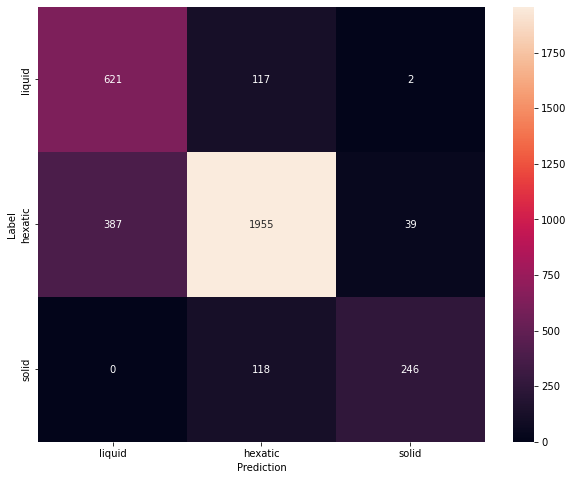

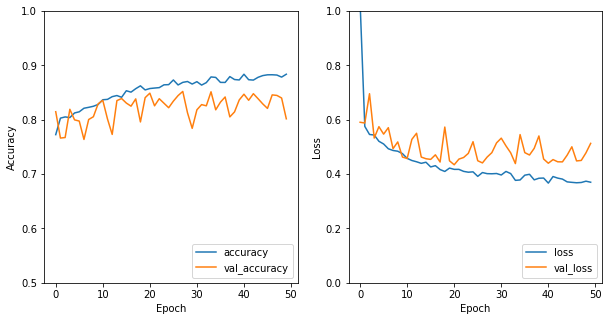

In [10]:
model.evaluate(X_test, y_test)
predictions = model.predict(X_test)
import seaborn as sns

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

confusion_mtx = tf.math.confusion_matrix(y_test, np.argmax(predictions, axis=1))

show_confusion_matrix(confusion_mtx, ['liquid', 'hexatic', 'solid'])

# plot the time evolution of the accuracy and loss
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

plot_history(history) 

# clear the session
tf.keras.backend.clear_session()